In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.affinity import rotate
from matplotlib.colors import BoundaryNorm

gdf = gpd.read_file("data/geojson_df.geojson")
sg_df = pd.read_csv("data/sg_baseline.csv").set_index("Dist")

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.affinity import rotate
from matplotlib.colors import BoundaryNorm

lie_mapping = {'green': 'Green','fairway': 'Fairway','bunker': 'Sand','tee': 'Tee','water': 'Recovery','hazard': 'Recovery'}

def preprocess_gdf(gdf, course):
    gdf = gdf[gdf['course_name_raw'] == course]
    gdf = gdf[gdf.geometry.notna() & gdf.geometry.is_valid & ~gdf.geometry.is_empty].copy()
    gdf = gdf.set_crs(None, allow_override=True)
    gdf = gdf.copy()
    gdf['hole_num'] = gdf['hole_num'].astype(str)
    return gdf

def get_zones(hole_gdf):
    zones = {}
    for key, label in lie_mapping.items():
        polys = hole_gdf[hole_gdf['course_element'] == key]
        if not polys.empty:
            unioned = polys.geometry.union_all()
            if not unioned.is_empty:
                zones[label] = unioned
    return zones

def generate_sg_grid(hole_gdf, sg_df, sg_step, res):
    minx, miny, maxx, maxy = hole_gdf.total_bounds
    aspect = (maxy - miny) / (maxx - minx)
    x_coords = np.linspace(minx, maxx, res)
    y_coords = np.linspace(miny, maxy, int(res * aspect))
    grid = gpd.GeoDataFrame(geometry=[Point(x, y) for y in y_coords for x in x_coords], crs=None)

    zones = get_zones(hole_gdf)
    green_poly = hole_gdf[hole_gdf['course_element'] == 'green'].geometry.union_all()
    hole_point = green_poly.centroid
    if hole_point.is_empty or not hole_point.is_valid:
        return None

    grid['lie'] = grid['geometry'].apply(lambda pt: next((lie for lie, poly in zones.items() if poly.contains(pt)), None))
    grid['dist'] = grid.geometry.distance(hole_point) / 0.9144

    def expected_strokes(row):
        if pd.isna(row['dist']) or pd.isna(row['lie']):
            return np.nan
        d = int(round(row['dist']))
        l = row['lie']
        return sg_df.at[d, l] if d in sg_df.index and l in sg_df.columns else np.nan

    grid['expected'] = grid.apply(expected_strokes, axis=1)
    grid = grid.dropna(subset=['expected'])
    if grid.empty:
        return None

    vmin, vmax = grid['expected'].min(), grid['expected'].max()
    bounds = np.arange(np.floor(vmin / sg_step) * sg_step, np.ceil(vmax / sg_step) * sg_step + sg_step, sg_step)
    norm = BoundaryNorm(bounds, ncolors=256)
    return grid, norm

def rotate_hole(hole_gdf):
    tee_centroid = hole_gdf[hole_gdf['course_element'] == 'tee'].geometry.union_all().centroid
    green_centroid = hole_gdf[hole_gdf['course_element'] == 'green'].geometry.union_all().centroid
    dx, dy = green_centroid.x - tee_centroid.x, green_centroid.y - tee_centroid.y
    angle = -np.degrees(np.arctan2(dy, dx)) + 90
    hole_gdf = hole_gdf.copy()
    hole_gdf['geometry'] = hole_gdf.geometry.apply(lambda geom: rotate(geom, angle, origin=tee_centroid))
    return hole_gdf


def plot_course_elements(ax, hole_gdf):
    for elem in hole_gdf['course_element'].unique():
        sub = hole_gdf[hole_gdf['course_element'] == elem]
        colour = sub['color'].iloc[0] if not sub['color'].isna().all() else '#cccccc'
        for geom in sub.geometry:
            if geom.is_empty or not geom.is_valid:
                continue
            ax.plot(*geom.exterior.xy, color='black', linewidth=0.5)
            ax.fill(*geom.exterior.xy, color=colour, alpha=0.6)

def plot_full_course(gdf, course='erin_hills', sg_df=None, plot_sg=False, sg_step=0.1, res=300):
    gdf = preprocess_gdf(gdf, course)
    minx, miny, maxx, maxy = gdf.total_bounds
    width, height = maxx - minx, maxy - miny
    aspect = height / width
    fig, ax = plt.subplots(figsize=(12, 12 * aspect))
    plot_course_elements(ax, gdf)

    if plot_sg and sg_df is not None:
        for hole in sorted(gdf['hole_num'].unique(), key=lambda x: int(x)):
            hole_gdf = gdf[gdf['hole_num'] == hole]
            result = generate_sg_grid(hole_gdf, sg_df, sg_step, res)
            if result:
                grid, norm = result
                grid.plot(ax=ax, column='expected', cmap='viridis', markersize=1, alpha=0.5, norm=norm)

    ax.set_title("Full Course Layout" + (" with Strokes Gained Overlay" if plot_sg else ""))
    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

def plot_single_hole(gdf, hole, course='erin_hills', sg_df=None, plot_sg=False, sg_step=0.1, res=300):
    gdf = preprocess_gdf(gdf, course)
    hole = str(hole)
    hole_gdf = gdf[gdf['hole_num'] == hole]
    if hole_gdf.empty:
        print(f"Hole {hole} not found in course {course}")
        return
    hole_gdf = rotate_hole(hole_gdf)
    minx, miny, maxx, maxy = hole_gdf.total_bounds
    width, height = maxx - minx, maxy - miny
    aspect = height / width
    fig, ax = plt.subplots(figsize=(6, 6 * aspect))
    plot_course_elements(ax, hole_gdf)

    if plot_sg and sg_df is not None:
        result = generate_sg_grid(hole_gdf, sg_df, sg_step, res)
        if result:
            grid, norm = result
            grid.plot(ax=ax, column='expected', cmap='viridis', markersize=1, alpha=0.5, norm=norm)

    ax.set_title(f"{course.replace('_', ' ').title()} – Hole {hole}")
    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

def plot_course_subplots(gdf, course='erin_hills', sg_df=None, plot_sg=False, sg_step=0.1, res=300):
    gdf = preprocess_gdf(gdf, course)
    hole_nums = sorted(gdf['hole_num'].unique(), key=lambda x: int(x))
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 25))
    axes = axes.flatten()

    for idx, hole in enumerate(hole_nums):
        ax = axes[idx]
        hole_gdf = gdf[gdf['hole_num'] == hole]
        if hole_gdf.empty:
            ax.axis("off")
            continue
        hole_gdf = rotate_hole(hole_gdf)
        plot_course_elements(ax, hole_gdf)
        if plot_sg and sg_df is not None:
            result = generate_sg_grid(hole_gdf, sg_df, sg_step, res)
            if result:
                grid, norm = result
                grid.plot(ax=ax, column='expected', cmap='viridis', markersize=1, alpha=0.5, norm=norm)
        ax.set_title(f"Hole {hole}")
        ax.axis("off")
        ax.set_aspect('equal')

    for ax in axes[len(hole_nums):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


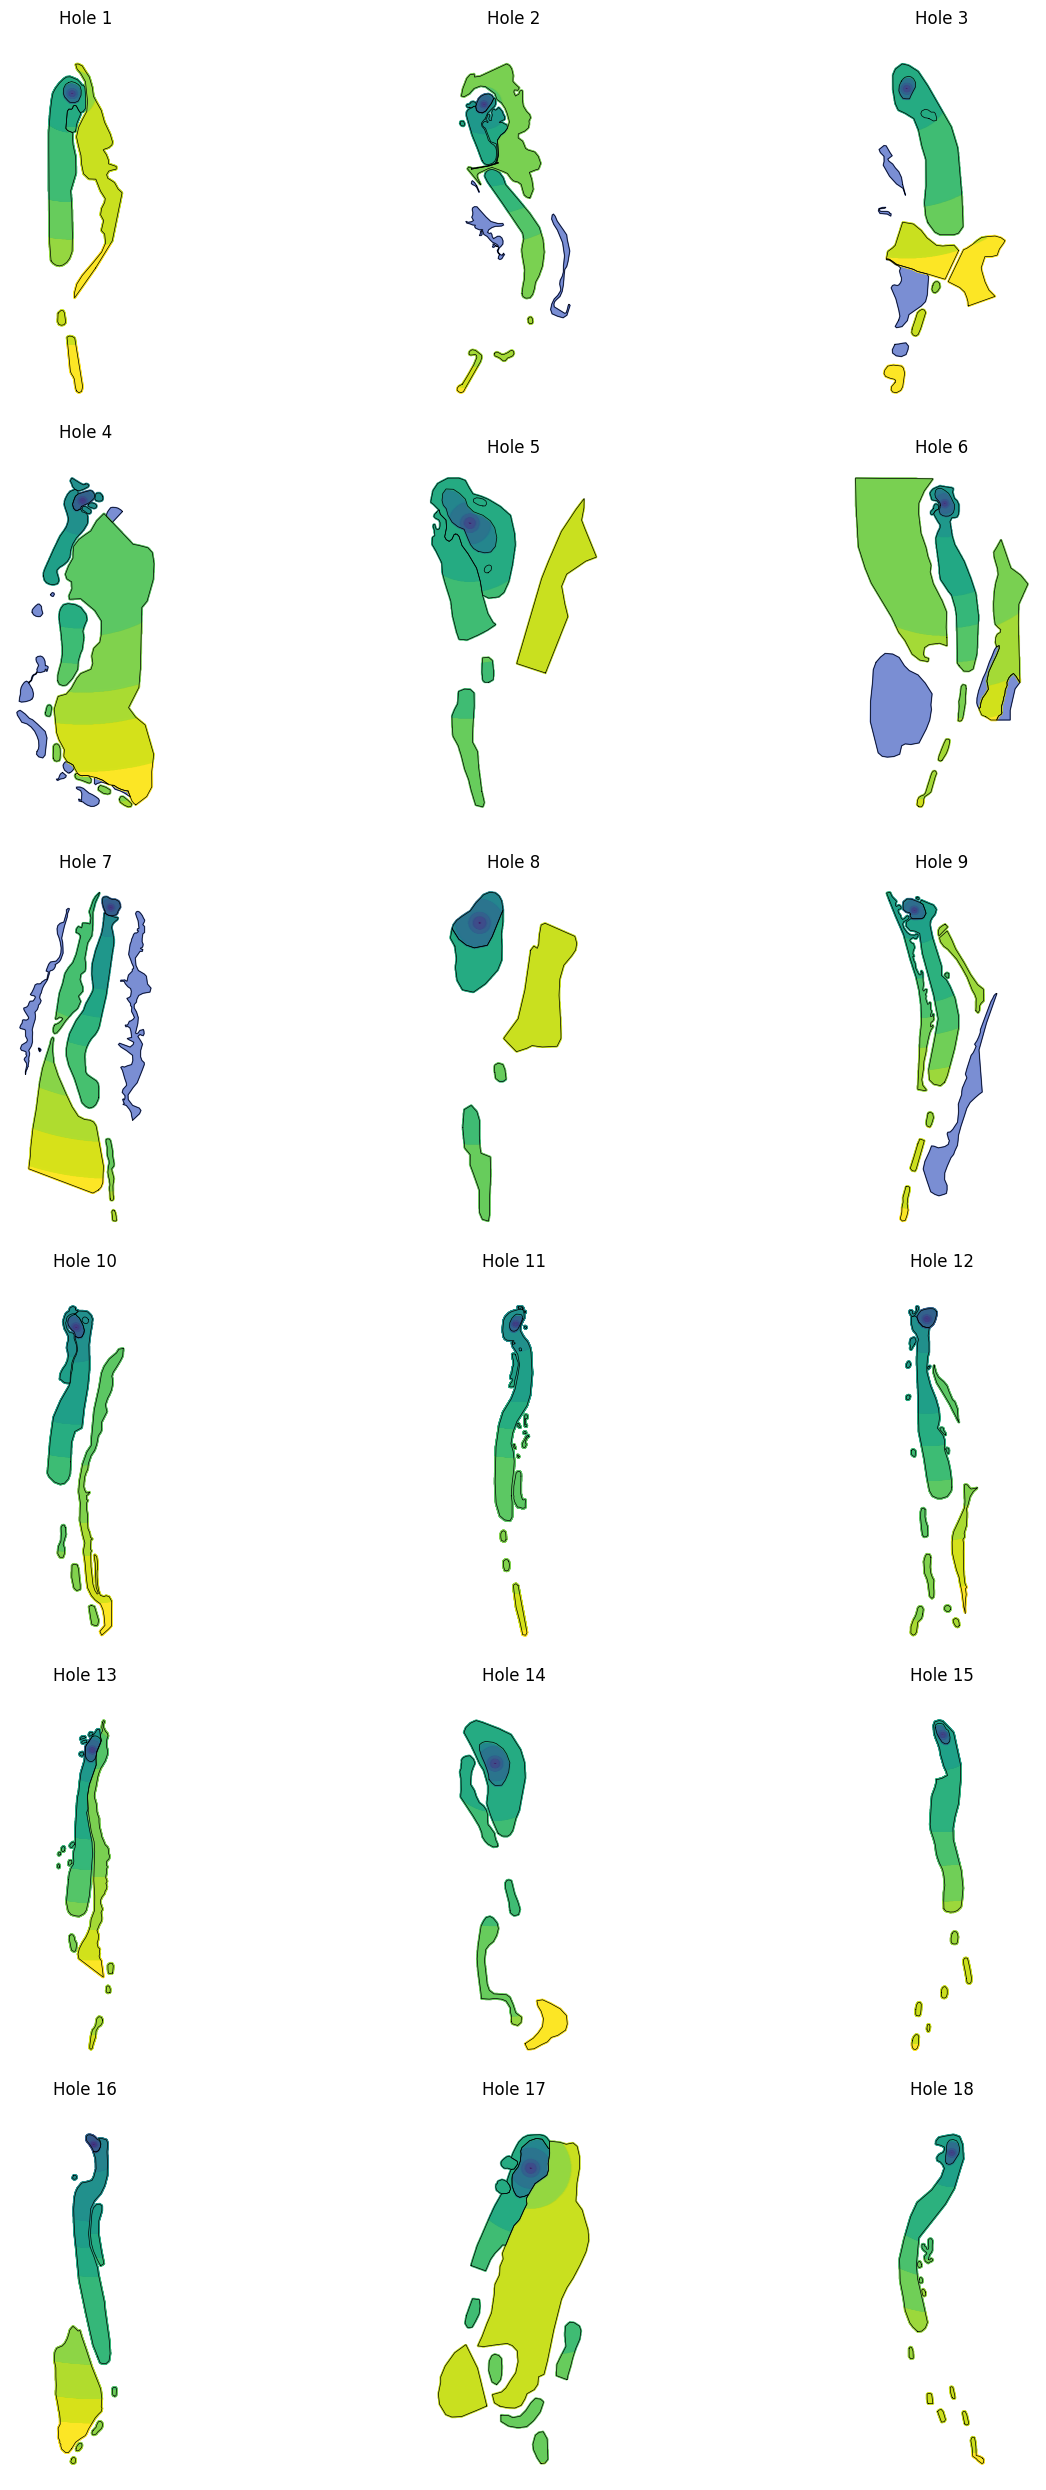

In [4]:
# plot_full_course(gdf, course='kiawah_island_ocean_course', sg_df=sg_df, plot_sg=False, sg_step=0.3)
plot_course_subplots(gdf, course='kiawah_island_ocean_course', sg_df=sg_df, plot_sg=True, sg_step=0.3)
# plot_single_hole(gdf, hole=1, course='kiawah_island_ocean_course', sg_df=sg_df, plot_sg=False, sg_step=0.1)